Add basic imports for data parsing.

In [1]:
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("../data/fake_data.csv", encoding='latin1')

In [4]:
data.head()

,sentence,word,label
0,0,save,word
1,0,Oklahoma,state
2,0,too,word
3,0,peace,word
4,0,alone,word


In [5]:
words = list(set(data['word'].values))

In [6]:
n_words = len(words)

In [7]:
tags = list(set(data['label'].values))

In [8]:
n_tags = len(tags)

In [9]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(), 
                                                     s["label"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        try:
            self.sentences = [s for s in self.grouped]
        except:
            raise

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [10]:
getter = SentenceGetter(data)

In [11]:
# this call does not work reliably in a notebook
sent = getter.get_next()

In [12]:
sentences = getter.sentences

In [13]:
max_len = 50

In [14]:
word2idx = {w:i for i, w in enumerate(words)}
tag2idx = {t:i for i, t in enumerate(tags)}

In [15]:
print(word2idx["Chris"])

819


In [16]:
print(tag2idx["dob"])

5


In [17]:
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [18]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [19]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["word"])

In [20]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [21]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["word"])

In [22]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [24]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [25]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)
model = Model(input, out)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])


W0822 07:56:59.661935 139838609221440 deprecation_wrapper.py:119] From /home/chris/anaconda3/envs/ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 07:56:59.709044 139838609221440 deprecation_wrapper.py:119] From /home/chris/anaconda3/envs/ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 07:56:59.718368 139838609221440 deprecation_wrapper.py:119] From /home/chris/anaconda3/envs/ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0822 07:56:59.747205 139838609221440 deprecation_wrapper.py:119] From /home/chris/anaconda3/envs/ml/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Pleas

In [26]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=5, validation_split=0.2, verbose=1)

W0822 07:57:03.970636 139838609221440 deprecation.py:323] From /home/chris/anaconda3/envs/ml/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7200 samples, validate on 1800 samples
Epoch 1/5
7200/7200 [==============================] - 33s 5ms/step - loss: 0.2196 - acc: 0.9464 - val_loss: 0.0687 - val_acc: 0.9709
Epoch 2/5
7200/7200 [==============================] - 32s 4ms/step - loss: 0.0427 - acc: 0.9846 - val_loss: 0.0255 - val_acc: 0.9903
Epoch 3/5
7200/7200 [==============================] - 33s 5ms/step - loss: 0.0148 - acc: 0.9962 - val_loss: 0.0077 - val_acc: 0.9981
Epoch 4/5
7200/7200 [==============================] - 33s 5ms/step - loss: 0.0052 - acc: 0.9987 - val_loss: 0.0052 - val_acc: 0.9986
Epoch 5/5
7200/7200 [==============================] - 34s 5ms/step - loss: 0.0028 - acc: 0.9994 - val_loss: 0.0049 - val_acc: 0.9978


In [27]:
hist = pd.DataFrame(history.history)

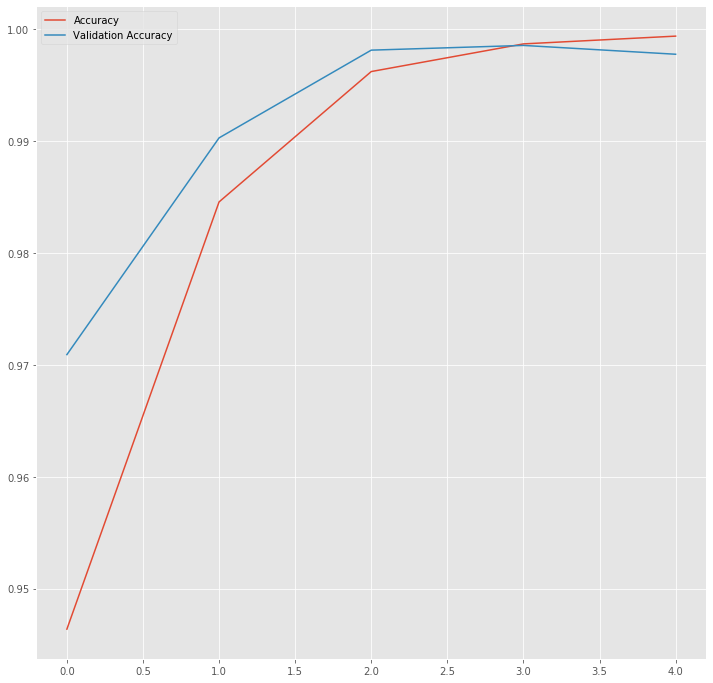

In [33]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

plt.figure(figsize=(12,12))
plt.plot(hist["acc"], label="Accuracy")
plt.plot(hist["val_acc"], label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

In [34]:
i = 25
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)

In [36]:
def get_tag(x, tags):
    if isinstance(x, np.ndarray):
        word = tags[np.argmax(x)]
    else:
        word = [t for i, t in zip(x, tags) if i > 0] 
    return word

In [37]:
truth = []
for l in y_test[i]:
    truth.append(get_tag(l, tags)[0])

In [38]:
print("{:15} {:8}     {:8}".format("Word", "Truth", "Pred"))
for w, tru, pred in zip(X_test[i], truth, p[0]):
    print("{:15}: ({:8}): {:8}".format(words[w], tru, tags[pred]))

Word            Truth        Pred    
49500          : (a       ): address 
Faulkner       : (a       ): address 
Run            : (a       ): address 
Apt            : (a       ): address 
PUNCT          : (p       ): punct   
529            : (a       ): address 
maybe          : (w       ): word    
west           : (w       ): word    
Congress       : (w       ): word    
throw          : (w       ): word    
rather         : (w       ): word    
trial          : (w       ): word    
they           : (w       ): word    
return         : (w       ): word    
remain         : (w       ): word    
word           : (w       ): word    
word           : (w       ): word    
word           : (w       ): word    
word           : (w       ): word    
word           : (w       ): word    
word           : (w       ): word    
word           : (w       ): word    
word           : (w       ): word    
word           : (w       ): word    
word           : (w       ): word    
word        

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [41]:
Y_test = [get_tag(i, tags) for elem in y_test for i in elem]

Y_pred = model.predict(X_test)

y_pred = [get_tag(i, tags) for pred in Y_pred for i in pred]


In [42]:
header = "  ".join(tags)
print("\t  {}".format(header))
confusion_matrix(Y_test, y_pred, labels=tags)

	  punct  zip_code  address  name  word  dob  phone  state  ssn  city


array([[  896,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    0,    95,     0,     0,     0,     0,    55,     0,     0,
           14],
       [    0,     0,   510,     6,     0,     0,     0,     0,     0,
            0],
       [    0,     1,     0,   231,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0, 46659,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,   348,     0,     0,     0,
            0],
       [    0,     4,     0,     0,     0,     0,   458,     0,     0,
            5],
       [    0,     0,     0,     0,     0,     0,     0,   173,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,   381,
            0],
       [    0,    48,     0,     0,     0,     0,     0,     1,     0,
          115]])

In [43]:
print(classification_report(Y_test, y_pred, target_names=tags))

              precision    recall  f1-score   support

       punct       1.00      0.99      0.99       516
    zip_code       0.86      0.70      0.77       164
     address       1.00      1.00      1.00       348
        name       0.97      1.00      0.99       232
        word       0.89      0.98      0.93       467
         dob       1.00      1.00      1.00       896
       phone       1.00      1.00      1.00       381
       state       0.99      1.00      1.00       173
         ssn       1.00      1.00      1.00     46659
        city       0.64      0.58      0.61       164

    accuracy                           1.00     50000
   macro avg       0.94      0.92      0.93     50000
weighted avg       1.00      1.00      1.00     50000

